# Ameritrade local API

This will be used to make API calls to Ameritrade. This will include authenticated and un-authenticated.

In [1]:
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
import matplotlib as plt

import importlib
import trading_functions as tf
importlib.reload(tf)

#import ameritrade_functions as amt
#importlib.reload(amt)

import ameritrade_functions as amc
importlib.reload(amc)

plt.rcParams['figure.figsize'] = (20, 8)
print(pd.__version__)

1.1.5


## Sample Usage

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:]
stock_quotes_file_name = 'data/stock_quotes.csv'

In [3]:
import trading_functions as tf
importlib.reload(tf)

datafun = tf.Data()
portfun = tf.Portfolio()
retfun = tf.Returns()
selfun = tf.Selection()

In [4]:
import ameritrade_functions as amc
importlib.reload(amc)
td_ameritrade = amc.AmeritradeRest(username, password, client_id)

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but that has not been coded yet.)

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

Some issues with the current system (I plan to fix these later) is that once the module opens the browser, you will need to open it on your screen. For some reason, if it's shrunk, it does not work properly. You will notice a flashing Chrome icon on your task bar. As soon as you start the authentication process, click on the icon to open the screen. At some time in the future I will move to another mechanism like flask to avoid needed the driver and to be able to run headless.

In [5]:
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


## Get your account data

There are two different account functions, one that just provides high level account data, and one that also returns investment information for each account.

There is a lot of data that Ameritrade provides. I have only selected the fields that I thought were interesting. The raw data is stored in the amc class, so if you would like to get different or additional data, you can pull the raw json string and parse it.

- td_ameritrade.positions_data
- td_ameritrade.account_data

These functions will return Pandas data frames.

In [6]:
portfolios_list = td_ameritrade.parse_portfolios_list()
display(portfolios_list.sample(5))
account_data = td_ameritrade.parse_accounts()
display(account_data)
portfilios = td_ameritrade.parse_portfolios()
display(portfilios)

,account,shortQuantity,averagePrice,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,assetType,cusip,symbol,description,type
14,#---5311,0.0,50.82645,-2.000000e-12,0.0,248.0,248.0,0.0,12695.12,12695.12,EQUITY,922020805,VTIP,0,0
9,#---5311,0.0,56.16900,0.000000e+00,0.0,140.0,140.0,0.0,8789.20,8789.20,EQUITY,922042874,VGK,0,0
11,#---5311,0.0,19.00000,4.000000e-12,0.0,900.0,900.0,0.0,23008.50,23008.50,EQUITY,98138J206,WKHS,0,0
21,#---5311,0.0,6.47486,0.000000e+00,0.0,500.0,500.0,0.0,3485.00,3485.00,EQUITY,33812L102,FIT,0,0
17,#---5311,0.0,232.60143,0.000000e+00,0.0,7.0,7.0,0.0,1955.80,1955.80,EQUITY,922908595,VBK,0,0


,initialBalances_cashBalance,initialBalances_totalCash,initialBalances_equity,initialBalances_moneyMarketFund,currentBalances_cashBalance,currentBalances_equity,currentBalances_moneyMarketFund,current_return
accountId,,,,,,,,
#---2021,0.0,0.0,7865.05,195.55,0.0,7865.05,195.55,0.0
#---9216,0.0,0.0,4461.58,115.53,0.0,4461.58,115.53,0.0
#---5311,0.0,0.0,126439.79,4295.01,0.0,126439.79,4295.01,0.0


,FGPHF,FIT,FNCL,FSTA,NNXPF,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
#---9216,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,4346.05
#---2021,5100.0,0.0,0.00,0.00,3180.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,7669.50
#---5311,5100.0,3485.0,2966.09,889.24,0.0,1973.79,3856.8,8669.43,5806.42,1955.8,1935.57,8789.2,34470.25,12695.12,2937.76,2686.86,6018.95,23008.50


## Lets narrow it down to one account

Here you can get the data for a specific account. The functions will work with the full data set, but I imagine each account would be treated differently when it comes to managing the investments.

In [7]:
account_portfolio_df = datafun.get_account_portfolio_data(portfolios_list, masked_account_number)
display(account_portfolio_df.head(2))
acct_port_market_df = portfun.get_market_values(account_portfolio_df)
display(acct_port_market_df)

,account,shortQuantity,averagePrice,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,assetType,cusip,symbol,description,type
6,#---5311,0.0,33.56771,0.0,0.0,231.0,231.0,0.0,8669.43,8669.43,EQUITY,808524805,SCHF,0,0
7,#---5311,0.0,39.28909,0.0,0.0,22.0,22.0,0.0,889.24,889.24,EQUITY,316092303,FSTA,0,0


,marketValue
symbol,
FGPHF,5100.00
FIT,3485.00
FNCL,2966.09
FSTA,889.24
MMDA1,4295.00
SCHA,1973.79
SCHE,3856.80
SCHF,8669.43
SCHM,5806.42


## Narrow further by investment type

Each investment has a type. You can restrict the data you work with to specifically a single type. This works well since investments like cash accounts, generally don't have trading fundamentals, so you won't want to try and pull ticker data for them.

For the remainder of this demo, we will work with 'EQUITY' investments.

In [8]:
equity_investments_df = portfun.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
cash_investments_df = portfun.get_investments_by_type(account_portfolio_df, investment_type='CASH_EQUIVALENT')
port_equi_values = portfun.get_market_values(equity_investments_df)

## Some things you can do with investments data

In [9]:
display(portfun.get_investment_symbols(port_equi_values))
display(portfun.get_account_value(port_equi_values))
display(portfun.get_portfolio_weights(port_equi_values))

['FGPHF',
 'FIT',
 'FNCL',
 'FSTA',
 'SCHA',
 'SCHE',
 'SCHF',
 'SCHM',
 'VBK',
 'VBR',
 'VGK',
 'VTI',
 'VTIP',
 'VWO',
 'VWOB',
 'VXF',
 'WKHS']

127244.78

,weight
symbol,
FGPHF,0.040080
FIT,0.027388
FNCL,0.023310
FSTA,0.006988
SCHA,0.015512
SCHE,0.030310
SCHF,0.068132
SCHM,0.045632
VBK,0.015370


# Fundamentals data

One you have a set of investments you want to work with, you will need to pull some historical data for them.

Eventually I plan to import the data into zipline, since they have an awesome set of analysis tools. But for now I'm using some functions I built to play with the data. 

You will need to be authenticated to pull the fundamentals. If this fails, it's probably because the token expired. Just re-authenticate and get a new token.

This can be skipped if you have already received and saved the fundamentals data.

In [55]:
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

Quitting current browser...
You have authorization


### Skip if you alrady have fundamentals

Unless you want to update them.

In [56]:
symbols = portfun.get_investment_symbols(port_equi_values)
portfolio_fundamentals = td_ameritrade.get_fundamentals(symbols, datetime.today().strftime('%Y-%m-%d'))
datafun.save_fundamentals(portfolio_fundamentals, stock_quotes_file_name)

## Read saved data

In [10]:
portfolio_fundamentals = datafun.read_fundamentals(stock_quotes_file_name)
display(portfolio_fundamentals.sample(5))

,close,date,high,low,open,ticker,volume
2256,136.05,2020-01-09,136.63,135.81,136.54,VBR,249233
4119,2.80,2020-05-12,3.02,2.79,3.00,WKHS,2160707
446,42.91,2019-11-21,43.10,42.79,43.10,FNCL,62222
3957,128.45,2020-09-22,128.64,126.48,127.78,VXF,191391
4217,25.28,2020-09-30,26.97,25.08,26.59,WKHS,23238003


# Analysis tools

Once you have the historical data (currently pulling 1 year from today), you can start to evaluate the stocks using different functions.

In [14]:
current_weights = portfun.get_portfolio_weights(port_equi_values)
port_close = datafun.get_close_values(portfolio_fundamentals)
display(port_close.head(2))
port_returns = retfun.compute_log_returns(port_close)
display(port_returns.head(2))

ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2019-10-30,0.14,5.86,41.80,36.60,71.73,26.36,32.97,57.56,186.19,132.04,55.84,154.72,49.13,42.18,80.5,119.35,2.82
2019-10-31,0.14,6.18,41.55,36.52,71.19,26.47,32.86,57.21,184.81,131.10,55.67,154.18,49.18,41.85,80.7,118.62,2.53


ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2019-10-31,0.0,0.053169,-0.005999,-0.002188,-0.007557,0.004164,-0.003342,-0.006099,-0.007439,-0.007145,-0.003049,-0.003496,0.001017,-0.007854,0.002481,-0.006135,-0.108518
2019-11-01,0.0,0.144395,0.013388,0.001642,0.016163,0.002264,0.009691,0.014404,0.016049,0.014614,0.007516,0.010645,0.001016,0.015412,0.000000,0.013980,0.079739


# To be moved

This will be moved to the trading functions

In [178]:
from sklearn.linear_model import LinearRegression

def factor_return_mean(returns_df):
    return returns_df.mean(axis=1).rename('factor_mean')

def factor_return_median(returns_df):
    return returns_df.median(axis=1).rename('factor_median')

def get_factor_exposures(factor_return_l, asset_return):
    lr = LinearRegression()
    X = np.array(factor_return_l.values)
    y = np.array(asset_return.values)
    lr.fit(X,y)
    return lr.coef_

def build_factor_exposures_df(factor_returns, returns_df):
    factor_exposure_l = []
    for i in range(len(returns_df.columns)):
        factor_exposure_l.append(get_factor_exposures(factor_returns, returns_df[returns_df.columns[i]]))

    return pd.DataFrame(np.array(factor_exposure_l), returns_df.columns, factor_returns.columns)

def build_stock_variances_df(factor_betas, factor_returns, returns):
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    
    return pd.DataFrame(np.diag(np.var(residuals_)), returns.columns, returns.columns)

def factor_covariance(factor_returns):
    return np.cov(factor_returns.T,ddof=1)

def portfolio_variance_using_factors(X, B, F, S):
    var_portfolio = X.T.dot(B.dot(F).dot(B.T) + S).dot(X)
    return var_portfolio

def compute_portfolio_variance(factor_returns, port_returns, weights):
    F = factor_covariance(factor_returns)
    B = build_factor_exposures_df(factor_returns, port_returns).values
    S = build_stock_variances_df(B, factor_returns, port_returns)
    X = np.array(weights).reshape((-1,1))
    return portfolio_variance_using_factors(X,B,F,S)

In [169]:
factor_return_mean_df = factor_return_mean(port_returns)
factor_return_median_df = factor_return_median(port_returns)
factor_returns = pd.concat([factor_return_mean_df, factor_return_median_df], axis=1)
print(f'Factor Names: {factor_returns.columns}')
var_portfolio = compute_portfolio_variance(factor_returns, port_returns, current_weights)
print(f'portfolio variance is:  {var_portfolio.sum():.8f}')

Factor Names: Index(['factor_mean', 'factor_median'], dtype='object')
portfolio variance is:  0.00059596


## PCA to compute portfolio variance

In [199]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    pca = PCA(num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    return  pca

def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    return pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)

def gen_factor_returns(pca, returns, factor_return_columns):
    return pd.DataFrame(pca.transform(returns), index=returns.index.values, columns=factor_return_columns)

def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor=252):
    
    common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    residuals_ = (returns - common_returns_)
    
    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)

def factor_cov_matrix(factor_returns, ann_factor=252):
 
    return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

def compute_portfolio_variance_PCA(port_returns, weights, number_of_factors=1, ann_factor=252):
    factor_names = list(range(0, number_of_factors))
    pca = fit_pca(port_returns, number_of_factors, 'full')
    factor_returns = gen_factor_returns(pca, port_returns, factor_names)
    F = factor_cov_matrix(factor_returns, ann_factor)
    B = factor_betas(pca, port_returns.columns, factor_names).values
    S = idiosyncratic_var_matrix(port_returns, FR, B, ann_factor)
    X = np.array(weights).reshape((-1,1))
    return portfolio_variance_using_factors(X,B,F,S)

def portfolio_variance_using_factors(X, B, F, S):
    var_portfolio = X.T.dot(B.dot(F).dot(B.T) + S).dot(X)
    return var_portfolio

In [201]:
var_portfolio = compute_portfolio_variance_PCA(port_returns, current_weights, len(current_weights), 1)
print(f'portfolio variance is:  {var_portfolio.sum():.8f}')

portfolio variance is:  0.00053376


In [202]:
class RiskModelPCA(object):
    def __init__(self, returns, ann_factor, num_factor_exposures):
        self.factor_names_ = list(range(0, num_factor_exposures))
        pca = self.fit_pca(port_returns, num_factor_exposures, 'full')
        self.factor_betas_ = self.factor_betas(pca, returns.columns.values, self.factor_names_)
        self.factor_returns_ = self.factor_returns(pca, returns, returns.index, self.factor_names_)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.factor_returns_, self.factor_betas_, ann_factor)

    def fit_pca(self, returns, num_factor_exposures, svd_solver):
        pca = PCA(num_factor_exposures, svd_solver=svd_solver)
        pca.fit(returns)
        return  pca
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)

    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)

    def idiosyncratic_var_matrix(self, returns, factor_returns, factor_betas, ann_factor):
        common_returns_ = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
        residuals_ = (returns - common_returns_)
        return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, returns.columns, returns.columns)
    
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)
    
    def compute_portfolio_variance(self, weights):
        X = np.array(weights).reshape((-1,1))
        return self.portfolio_variance_using_factors(X,self.factor_betas_.values,self.factor_cov_matrix_,self.idiosyncratic_var_matrix_)
    
    def portfolio_variance_using_factors(self, X, B, F, S):
        var_portfolio = X.T.dot(B.dot(F).dot(B.T) + S).dot(X)
        return var_portfolio

In [200]:
num_factor_exposures = len(current_weights)
rm = RiskModelPCA(port_returns, 1, num_factor_exposures)
var_portfolio = rm.compute_portfolio_variance(current_weights)
print(f'portfolio variance is:  {var_portfolio.sum():.8f}')

portfolio variance is:  0.00053376


In [60]:
port_close_monthly = datafun.resample_prices(port_close, freq='M')
display(port_close_monthly.head(2))

ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2019-10-31,0.140,6.18,41.55,36.5200,71.19,26.47,32.86,57.21,184.81,131.10,55.67,154.18,49.18,41.85,80.70,118.62,2.53
2019-11-30,0.109,6.96,43.55,36.9969,73.98,26.29,33.27,59.43,196.20,134.35,56.39,160.02,49.19,42.06,79.92,124.01,2.75


## Weighted portfolio returns

The current portfolio weights are a Pandas series with the index being the ticker name. This needs to be converted into an array, then reshaped.

In [100]:
weighted_port_returns = portfun.portfolio_log_returns(close, current_weights)
display(weighted_port_returns.sample(5))

ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2020-02-13,0.000000,0.000000,0.000008,0.000043,0.000041,-0.000331,-0.000499,0.000099,0.000072,0.000009,-0.000474,-0.000115,0.000086,-0.000252,0.000017,0.000170,0.007673
2020-09-01,0.000000,-0.000226,0.000080,-0.000006,0.000214,0.000576,0.000132,0.000586,0.000189,0.000154,-0.000079,0.002489,-0.000084,0.000471,0.000014,0.000469,0.016738
2020-07-08,-0.010309,0.000092,0.000268,-0.000023,0.000126,0.000822,0.000556,0.000331,0.000208,0.000061,0.000911,0.002300,-0.000042,0.000623,0.000091,0.000519,-0.001778
2020-08-11,0.002436,-0.000135,0.000278,-0.000053,-0.000082,-0.000105,0.000268,-0.000033,-0.000148,0.000024,0.000279,-0.002281,0.000000,-0.000087,-0.000031,-0.000297,0.000462
2019-12-27,0.004593,-0.000699,-0.000035,0.000032,-0.000077,0.000090,0.000209,-0.000047,-0.000064,-0.000044,0.000329,-0.000258,0.000043,0.000032,0.000090,-0.000131,-0.011273


## Volatility

In [74]:
volatility = pd.Series(selfun.volatility(port_returns), symbols)
display(volatility)

FGPHF    0.175284
FIT      0.016740
FNCL     0.028215
FSTA     0.017398
SCHA     0.026123
SCHE     0.020627
SCHF     0.019635
SCHM     0.024404
VBK      0.023310
VBR      0.026940
VGK      0.021372
VTI      0.021481
VTIP     0.003310
VWO      0.020574
VWOB     0.011861
VXF      0.024665
WKHS     0.073824
dtype: float64

## Portfolio optimization

In [101]:
new_weights = np.round(portfun.optimize_portfolio(port_returns, current_weights, scale=2.0), 6)
new_weights = pd.Series(new_weights, symbols)
display(new_weights)

FGPHF    0.032866
FIT      0.028653
FNCL     0.023635
FSTA     0.007468
SCHA     0.015777
SCHE     0.030894
SCHF     0.070217
SCHM     0.047012
VBK      0.015761
VBR      0.015556
VGK      0.071285
VTI      0.282318
VTIP     0.106682
VWO      0.023601
VWOB     0.022882
VXF      0.048582
WKHS     0.156810
dtype: float64

In [149]:
port_volume = datafun.get_values_by_date(portfolio_fundamentals, 'volume').fillna(0)
dollar_volume_weights = portfun.generate_dollar_volume_weights(port_close, port_volume)

In [150]:
new_weights = np.round(portfun.get_optimal_weights(port_returns, dollar_volume_weights.iloc[-1], scale=2.0), 6)
new_weights = pd.Series(new_weights, symbols)
display(new_weights)

FGPHF    0.000011
FIT      0.011535
FNCL     0.003680
FSTA     0.002798
SCHA     0.059679
SCHE     0.013502
SCHF     0.049059
SCHM     0.012133
VBK      0.018937
VBR      0.019137
VGK      0.109192
VTI      0.261409
VTIP     0.019825
VWO      0.242350
VWOB     0.006015
VXF      0.074789
WKHS     0.095950
dtype: float64

In [153]:
port_returns.head()

ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2019-10-31,0.0,0.053169,-0.005999,-0.002188,-0.007557,0.004164,-0.003342,-0.006099,-0.007439,-0.007145,-0.003049,-0.003496,0.001017,-0.007854,0.002481,-0.006135,-0.108518
2019-11-01,0.0,0.144395,0.013388,0.001642,0.016163,0.002264,0.009691,0.014404,0.016049,0.014614,0.007516,0.010645,0.001016,0.015412,0.000000,0.013980,0.079739
2019-11-04,0.0,-0.014105,0.008513,-0.009890,0.006338,0.009379,0.005710,0.005498,0.001543,0.009501,0.004980,0.003651,0.000000,0.007268,-0.004346,0.003817,0.010889
2019-11-05,0.0,0.002837,0.003760,0.002482,0.001784,0.004099,-0.001199,0.000685,-0.000106,0.000819,-0.002131,-0.000896,-0.000203,0.004893,-0.004490,-0.000829,-0.098565
2019-11-06,0.0,-0.004258,0.003512,0.004123,-0.005361,-0.002980,-0.000300,-0.002400,-0.004904,-0.003503,-0.000533,-0.000448,0.000812,-0.001628,0.002497,-0.004153,-0.020121


In [160]:
all_rebalanced_weights = np.round(portfun.rebalance_portfolio(port_returns, dollar_volume_weights[1:], 2, 3), 6)
new_weights = pd.Series(all_rebalanced_weights[-1], symbols)
display(new_weights)

FGPHF    0.000001
FIT      0.009633
FNCL     0.001610
FSTA     0.002173
SCHA     0.012251
SCHE     0.017538
SCHF     0.077592
SCHM     0.008400
VBK      0.026328
VBR      0.020343
VGK      0.170880
VTI      0.298808
VTIP     0.016435
VWO      0.213997
VWOB     0.007745
VXF      0.016959
WKHS     0.099309
dtype: float64

## Stopped here

From this point further more work needs to be done.

In [379]:
portfolio_fundamentals = datafun.read_fundamentals(portfolio_file_name)
close = datafun.get_close_values(portfolio_fundamentals)
close = datafun.resample_prices(close, freq='D').dropna()
symbols = portfun.get_investment_symbols(close)
returns = retfun.compute_log_returns(close).dropna()
display(selfun.get_top_n(returns, 5))
display(selfun.get_top_n(-1*returns, 5))

ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2019-10-31,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2019-11-01,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1
2019-11-04,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1
2019-11-05,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2019-11-06,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
2020-10-27,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0
2020-10-28,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0


ticker,FGPHF,FIT,FNCL,FSTA,SCHA,SCHE,SCHF,SCHM,VBK,VBR,VGK,VTI,VTIP,VWO,VWOB,VXF,WKHS
date,,,,,,,,,,,,,,,,,
2019-10-31,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1
2019-11-01,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
2019-11-04,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
2019-11-05,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1
2019-11-06,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1
2020-10-27,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1
2020-10-28,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0


In [91]:
display(tf.calculate_arithmetic_rate_of_return(port_close))
display(tf.compute_log_returns(port_close))
display(tf.volatility(port_close))

AttributeError: module 'trading_functions' has no attribute 'calculate_arithmetic_rate_of_return'

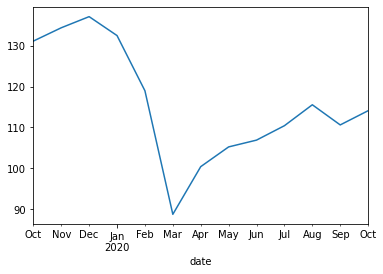

In [92]:
port_close_monthly['VBR'].plot()

In [125]:
long_df = tf.get_top_n(monthly_returns, 1)
short_df = tf.get_top_n(-1*monthly_returns, 0)

tf.portfolio_returns(long_df, short_df, lookahead_returns, 1)

ticker,AAPL,FB,GOOG,TSLA
date,,,,
2019-10-31,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN
2019-12-31,0.000000,0.000000,0.000000,0.046592
2020-01-31,0.000000,0.000000,0.000000,0.237360
2020-02-29,0.000000,0.000000,0.000000,0.441578
2020-03-31,-0.124201,0.000000,0.000000,0.000000
2020-04-30,0.000000,0.000000,0.000000,-0.242782
2020-05-31,0.000000,0.204799,0.000000,0.000000
2020-06-30,0.000000,0.000000,0.000000,0.065730


In [126]:
tf.calculate_simple_moving_average(3, monthly_close)

ticker,AAPL,FB,GOOG,TSLA
date,,,,
2019-10-31,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN
2019-12-31,67.471667,199.513333,1300.696667,70.879333
2020-01-31,72.534167,202.933333,1358.736667,93.256000
2020-02-29,73.043333,199.876667,1370.193333,115.792667
2020-03-31,69.763333,187.060000,1312.123333,122.837333
2020-04-30,68.454167,187.993333,1283.600000,131.591333
2020-05-31,72.169167,198.866667,1313.463333,142.725333
2020-06-30,81.378333,218.956667,1397.063333,179.779333


In [127]:
tf.volatility(long_df)

ticker
AAPL    0.375534
FB      0.277350
GOOG    0.375534
TSLA    0.518875
dtype: float64

In [162]:
close = tf.get_values_by_date(fundamentals_df, 'close')
tf.annualized_volatility(close)

ticker
AAPL    1.150695
FB      1.106763
GOOG    1.024521
TSLA    1.732148
dtype: float64

## From Project 2

In [129]:
fundamentals_df = td_ameritrade.read_fundamentals(test_file_name)

In [163]:
close = tf.resample_prices(tf.get_values_by_date(fundamentals_df, 'close'), freq='D').dropna()
high = tf.resample_prices(tf.get_values_by_date(fundamentals_df, 'high'), freq='D').dropna()
low = tf.resample_prices(tf.get_values_by_date(fundamentals_df, 'low'), freq='D').dropna()

In [164]:
close

ticker,AAPL,FB,GOOG,TSLA
date,,,,
2019-10-30,60.8150,188.25,1261.29,63.002
2019-10-31,62.1900,191.65,1260.11,62.984
2019-11-01,63.9550,193.62,1273.74,62.662
2019-11-04,64.3750,194.72,1291.37,63.494
2019-11-05,64.2825,194.32,1292.03,63.444
...,...,...,...,...
2020-10-26,115.0500,277.11,1590.45,420.280
2020-10-27,116.6000,283.29,1604.26,424.680
2020-10-28,111.2000,267.67,1516.62,406.020


In [133]:
lookback_days = 50
lookback_high, lookback_low = tf.get_high_lows_lookback(high, low, lookback_days)
signal = tf.get_long_short(close, lookback_high, lookback_low)
signal_5 = tf.filter_signals(signal, 5)
signal_10 = tf.filter_signals(signal, 10)
signal_20 = tf.filter_signals(signal, 20)

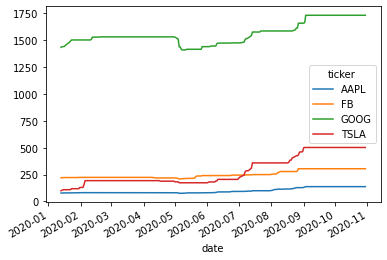

In [134]:
lookback_high.plot()

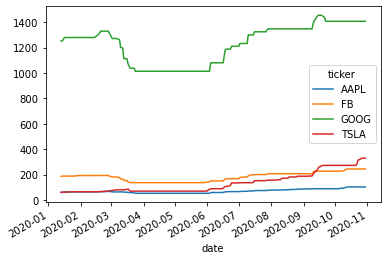

In [135]:
lookback_low.plot()

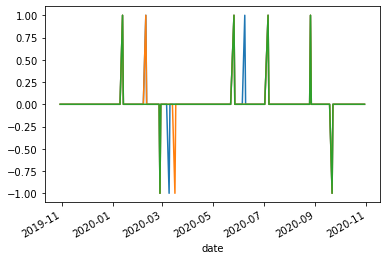

In [136]:
signal_5['GOOG'].tail(365).plot()
signal_10['GOOG'].tail(365).plot()
signal_20['GOOG'].tail(365).plot()

In [137]:
lookahead_5 = tf.get_lookahead_prices(close, 5)
lookahead_10 = tf.get_lookahead_prices(close, 10)
lookahead_20 = tf.get_lookahead_prices(close, 20)

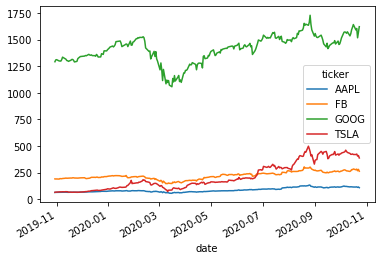

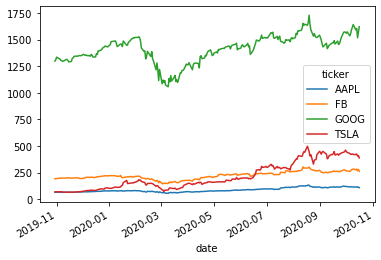

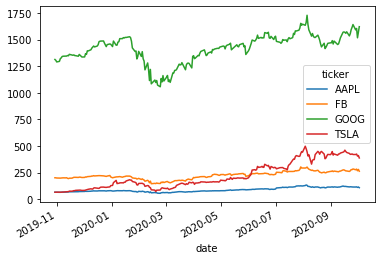

In [138]:
lookahead_5.plot()
lookahead_10.plot()
lookahead_20.plot()

In [139]:
price_return_5 = tf.get_return_lookahead(close, lookahead_5)
price_return_10 = tf.get_return_lookahead(close, lookahead_10)
price_return_20 = tf.get_return_lookahead(close, lookahead_20)

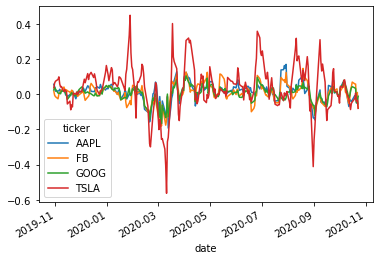

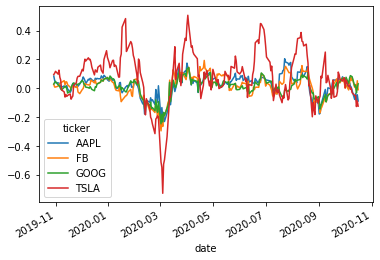

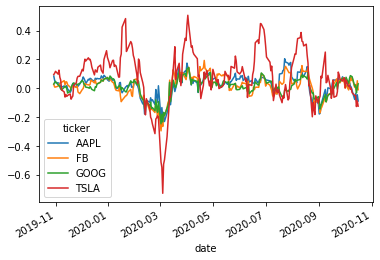

In [140]:
price_return_5.plot()
price_return_10.plot()
price_return_10.plot()

In [ ]:
signal_return_5 = tf.get_signal_return(signal_5, price_return_5)
signal_return_10 = tf.get_signal_return(signal_10, price_return_10)
signal_return_20 = tf.get_signal_return(signal_20, price_return_20)

In [ ]:
signal_return_5.plot()
signal_return_10.plot()
signal_return_20.plot()

In [ ]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()


# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_5.head(10)

In [ ]:
ks_values_5, p_values_5 = tf.calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = tf.calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = tf.calculate_kstest(long_short_signal_returns_20)

print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

In [ ]:
ks_threshold = 0.80
outliers_5 = tf.find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_10 = tf.find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = tf.find_outliers(ks_values_20, p_values_20, ks_threshold)

outlier_tickers = outliers_5.union(outliers_10).union(outliers_20)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

In [ ]:
good_tickers = list(set(close.columns) - outlier_tickers)

In [ ]:
good_tickers

In [ ]:
signal_return_5.hist()
signal_return_10.hist()
signal_return_20.hist()

## Risk and Return

In [14]:
fundamentals_df = tf.read_fundamentals(test_file_name)

In [165]:
close = tf.resample_prices(amt.get_date_values(fundamentals_df, 'close'), freq='D').dropna()
returns = tf.compute_log_returns(close).dropna().T.values
cov_returns = tf.covariance_matrix(returns)
print(cov_returns)

[[0.00083212 0.00062855 0.00052454 0.00082426]
 [0.00062855 0.00079261 0.00053557 0.00067051]
 [0.00052454 0.00053557 0.00056547 0.00064061]
 [0.00082426 0.00067051 0.00064061 0.00301232]]
